# Hello Numerai

In [4]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm cloudpickle pyarrow

# Inline plots
%matplotlib inline

## 1. Dataset  

Let's see what files are available in the API

In [5]:
# NumerAPI is the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# v4.1 is the latest version of the dataset
[f for f in napi.list_datasets() if f.startswith("v4.1")]

['v4.1/features.json',
 'v4.1/live.parquet',
 'v4.1/live_example_preds.csv',
 'v4.1/live_example_preds.parquet',
 'v4.1/live_int8.parquet',
 'v4.1/meta_model.parquet',
 'v4.1/train.parquet',
 'v4.1/train_int8.parquet',
 'v4.1/validation.parquet',
 'v4.1/validation_example_preds.csv',
 'v4.1/validation_example_preds.parquet',
 'v4.1/validation_int8.parquet']

Let's start by downloading `train.parquet` - the historical training data.

In [6]:
import pandas as pd
import json

# Download the training data and feature metadata
# This will take about 1 minute 🍵
napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

# In this notebook, we will be using the "small" feature set to save time and memory
# In practice, you will likely want to use all the features to maximize your model's performance
feature_metadata = json.load(open("v4.1/features.json"))
feature_cols = feature_metadata["feature_sets"]["medium"]

# Load the training data but only the "small" subset of features
training_data = pd.read_parquet("v4.1/train.parquet", columns= ["era"] + feature_cols + ["target"])

# Let's take a look
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 5)
training_data.describe()

2023-07-10 10:10:49,588 INFO numerapi.utils: target file already exists
2023-07-10 10:10:49,588 INFO numerapi.utils: download complete
2023-07-10 10:10:50,712 INFO numerapi.utils: target file already exists
2023-07-10 10:10:50,713 INFO numerapi.utils: download complete


,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,...,feature_yoruban_unapplied_tawse,target
count,2.420521e+06,2.420521e+06,...,2.085311e+06,2.420521e+06
mean,4.999783e-01,4.999783e-01,...,4.999787e-01,5.000148e-01
std,3.535955e-01,3.535955e-01,...,3.535926e-01,2.230465e-01
min,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00
25%,2.500000e-01,2.500000e-01,...,2.500000e-01,2.500000e-01
50%,5.000000e-01,5.000000e-01,...,5.000000e-01,5.000000e-01
75%,7.500000e-01,7.500000e-01,...,7.500000e-01,5.000000e-01
max,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00


Each row in the dataset corresponds to a stock at a specific point in time, represented by the `era` column.

For each `era`, the number of rows is the same as the number of stocks in Numerai's investable universe at that point in time.

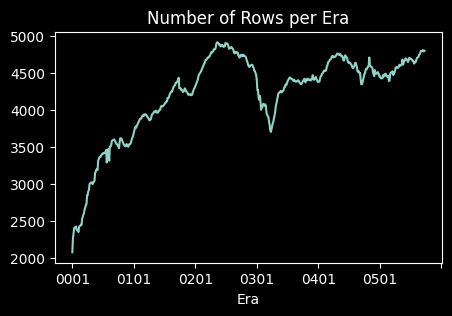

In [4]:
# Plot the number of rows per era
training_data.groupby("era").size().plot(title="Number of Rows per Era", figsize=(5, 3), xlabel="Era");

The `features` are quantitative attributes (e.g P/E ratio) known about the stocks at the point in time.

Feature values are regularized into 5 equal bins between 0 and 1 per era. This heavy regularization is to avoid overfitting as the underlying financial data is extremely noisy.

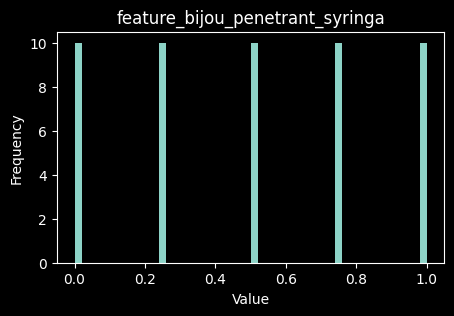

In [5]:
# Plot density histogram of the first feature
training_data[feature_cols[0]].plot(kind="hist", title=feature_cols[0], figsize=(5, 3), xlabel="Value", density=True, bins=50);

The `target` is a measure of stock market returns 20 days into the future. Your task is to predict this value given out of sample features.

The target value has also been regularized but into 5 unequal bins. The distribution of target values map to the distribution of returns across the stock market.

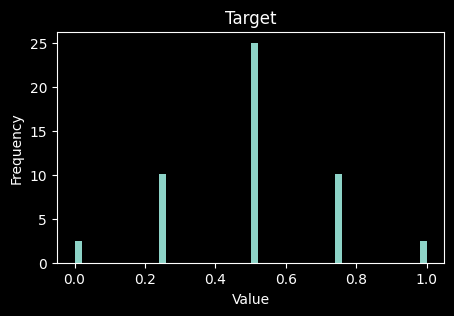

In [6]:
# Plot density histogram of the target
training_data["target"].plot(kind="hist", title="Target", figsize=(5, 3), xlabel="Value", density=True, bins=50);

## 2. Modeling
Let's train our first model.

Here we will be using LGBM but you are free to use any tool or framework of your choice.

Learn more about tree based models from our Chief Scientist MDO: https://www.youtube.com/watch?v=w8Y7hY05z7k

In [7]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
import lightgbm as lgb

try:
  # Load trained model if it exists
  model = lgb.Booster(model_file='small_lgb.model');
except lgb.basic.LightGBMError:
  # Otherwise train and save the model
  # This will take about 2 minutes 🍵
  model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2 ** 5,
    colsample_bytree=0.1
  )
  model.fit(
    training_data[feature_cols],
    training_data["target"]
  );
  # Save model to disk
  model.booster_.save_model("small_lgb.model");

[LightGBM] [Fatal] Could not open small_lgb.model


Now let's evaluate our model's performance on the out of sample validation dataset

In [8]:
# Download validation data
# This will take about 2 minutes 🍵
napi.download_dataset("v4.1/validation.parquet");

# Load the validation data but only the "small" subset of features
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"])

# Filter for data_type == "validation"
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]

# Generate predictions against the out of sample validation features
# This will take about 2 minutes 🍵
validation_data["prediction"] = model.predict(validation_data[feature_cols])
validation_data[["era", "prediction", "target"]]

2023-07-08 13:58:44,235 INFO numerapi.utils: starting download
v4.1/validation.parquet: 1.59GB [01:56, 13.6MB/s]                             


,era,prediction,target
id,,,
n000101811a8a843,0575,0.488841,0.75
n001e1318d5072ac,0575,0.495411,0.00
n002a9c5ab785cbb,0575,0.502395,0.50
n002ccf6d0e8c5ad,0575,0.507658,0.00
n0051ab821295c29,0575,0.486678,0.50
...,...,...,...
nffdf84066bf469b,1064,0.492729,0.25
nfff12e64e9a6fb6,1064,0.504522,0.50
nfff134941c033f8,1064,0.488877,0.50


In [9]:
from scipy import stats
import numpy as np

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0
    centered_target = target - target.mean()
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

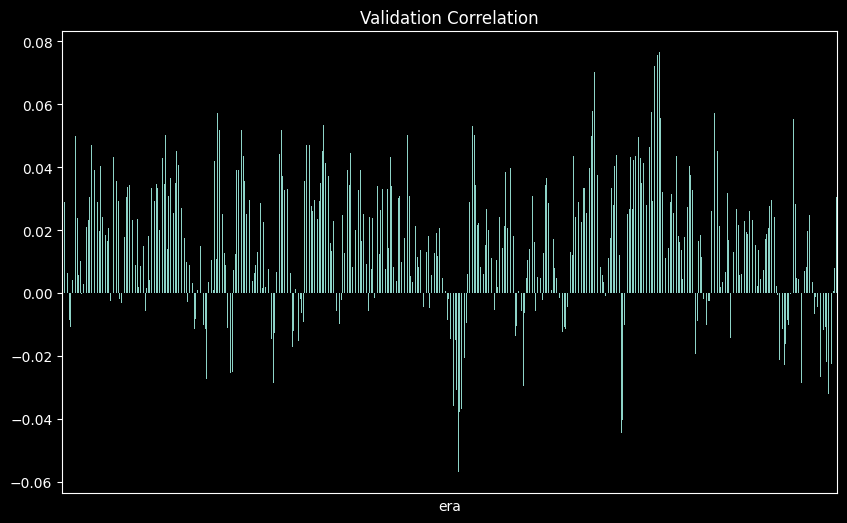

In [10]:
# Compute the per-era correlation between our predictions and the target values
per_era_corr = validation_data.groupby("era").apply(lambda x: numerai_corr(x["prediction"], x["target"]))

# Plot the per-era correlation
per_era_corr.plot(kind="bar", title="Validation Correlation", figsize=(10, 6), xticks=[]);

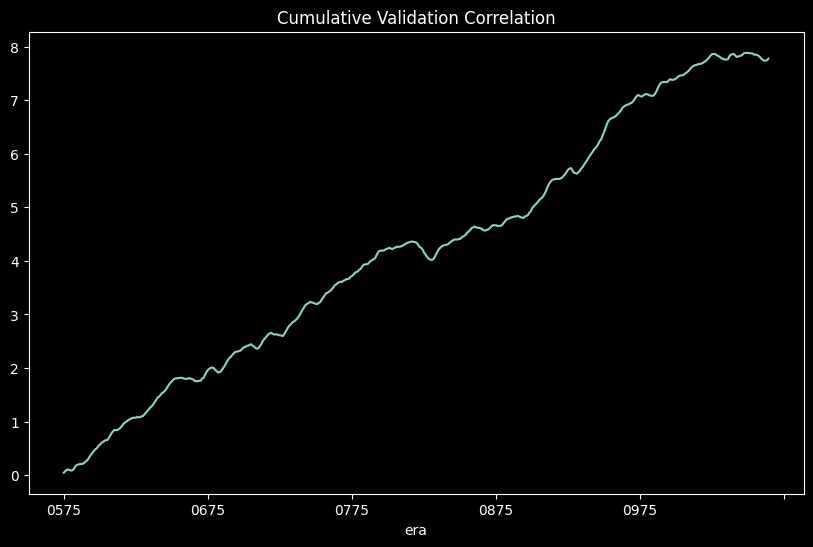

In [11]:
# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(kind="line", title="Cumulative Validation Correlation", figsize=(10, 6));

In [12]:
# compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
max_drawdown = -(per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

pd.DataFrame({
    "Mean": corr_mean,
    "Standard Deviation": corr_std,
    "Sharpe Ratio": corr_sharpe,
    "Max Drawdown": max_drawdown
}, index=["Value"]).T

,Value
Mean,0.015871
Standard Deviation,0.021359
Sharpe Ratio,0.743028
Max Drawdown,-0.342537


`Mean` correlation is the primary measure of your model's performance. An mean correlation above 0.02 is considered good.

`Sharpe` is a measure of your model's consistency, a concept borrowed from finance where it usually refers to risk adjusted returns of an investment strategy. In Numerai, we compute sharpe as the average correlation divided by the standard deviation of correlations. A sharpe above 1 is considered good.

`Max drawdown` is a measure of your model's risk, another concept borrowed from finance where it usually refers to the maximum financial loss suffered by an investment strategy. In Numerai, we compute max drawdown as the maximum peak to trough drop in cumulative validation correlation. A max drawdown below 0.1 in magnitude is considered good.

## 3. Submissions
Unlike Kaggle competitions where models are often evaluated based on their performance on a hold out test set, Numerai evaluates models based on their <ins>live performance</ins> in the real stock market.

Every Tuesday-Saturday, a new live era of features is released, representing the current state of the stock market. Your task is to use the live features to generate live predictions and submit them to Numerai.

In [13]:
# Check the current round number
current_round_number = napi.get_current_round()

# Download latest live features for the current round number
napi.download_dataset("v4/live.parquet", f"v4/live_{current_round_number}.parquet")

# Load live features
live_features = pd.read_parquet(f"v4/live_{current_round_number}.parquet", columns=feature_cols)

# Generate live predictions with our trained model
live_predictions = model.predict(live_features[feature_cols])

# Format submission
submission = pd.Series(live_predictions, index=live_features.index).to_frame("prediction")
submission

2023-07-08 14:01:04,427 INFO numerapi.utils: starting download
v4/live_523.parquet: 3.38MB [00:01, 2.57MB/s]                            


,prediction
id,
n001c25a620fca93,0.496357
n003b4b75ba8b318,0.497495
n0050ad62806f08f,0.492622
n006b94c09b1ceff,0.501591
n006c90e14908b26,0.517594
...,...
nffdc1f4dee6afd5,0.494230
nffe0cfbd4e2363d,0.499913
nffee106359ae1ae,0.491996


The simplest way to automate this daily process is to upload your model to Numerai and let Numerai take care of running it daily to generate live predictions.

You can also host your own model if you prefer, see our [docs](https://docs.numer.ai/numerai-tournament/submissions#automation) for more advanced examples.

In [14]:
# Wrap your model with a function that takes live features and returns live predictions
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_cols])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

In [15]:
# Quick test
predict(live_features)

,prediction
id,
n001c25a620fca93,0.496357
n003b4b75ba8b318,0.497495
n0050ad62806f08f,0.492622
n006b94c09b1ceff,0.501591
n006c90e14908b26,0.517594
...,...
nffdc1f4dee6afd5,0.494230
nffe0cfbd4e2363d,0.499913
nffee106359ae1ae,0.491996


In [16]:
# Use the cloudpickle library to serialize your function
import cloudpickle
p = cloudpickle.dumps(predict)
with open("predict.pkl", "wb") as f:
    f.write(p)

In [17]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict.pkl')
except:
    pass

That's it! Now head back to [numer.ai](https://numer.ai/tutorial/hello-numerai) to upload your model!